# Grid World --- past all grids
##### Charles Zhang
##### Jun 17

###  1. Cover and Get Back

In [1]:
import numpy as np

In [2]:
BOARD_ROWS = 4
BOARD_COLS = 5
START = (0, 0)
END = (0, 0)

In [3]:
class State:

    def __init__(self, state=START):
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.state = state    # tuple of the coordinate
        self.is_end = False

    def check_end(self):
        if self.state == END:
            self.is_end = True

    def next_position(self, action):
        if action == "up":
            next_state = (self.state[0] - 1, self.state[1])
        elif action == "down":
            next_state = (self.state[0] + 1, self.state[1])
        elif action == "left":
            next_state = (self.state[0], self.state[1] - 1)
        else:
            next_state = (self.state[0], self.state[1] + 1)
        # boundary condition 
        if (next_state[0] >= 0) and (next_state[0] < BOARD_ROWS):
            if (next_state[1] >= 0) and (next_state[1] < BOARD_COLS):
                return next_state
        return self.state

In [4]:
class Agent:

    def __init__(self):
        self.actions = ["up", "down", "left", "right"]      # space
        self.State = State()
        self.is_end = self.State.is_end
        self.alpha = 0.3      # learning rate
        self.exp_rate = 1     # epsilon-greedy parameter
        self.decay_gamma = 0.9
        self.Q_values = {}             # init Q table (dict)
        for i in range(BOARD_ROWS):    
            for j in range(BOARD_COLS):
                self.Q_values[(i, j)] = {}
                for a in self.actions:
                    self.Q_values[(i, j)][a] = 0
        # init a list to check if each grid is past          
        self.past_all = np.zeros((BOARD_ROWS, BOARD_COLS), dtype=bool).tolist()
        self.steps = []         # store the steps for each episode 
    
    def optimal_action(self):
        # greedy move
        max_value = -10000
        action = ""
        for a in self.actions:
            next_value = self.Q_values[self.State.state][a]
            if next_value >= max_value:
                action = a
                max_value = next_value
        return action
    
    def get_action(self):
        """
        The agent should choose randomly among the positions that have
        not been visited, and if all possible positions are visited, 
        then move randomly and receive a negative reward
        """
        if np.random.uniform(0, 1) <= self.exp_rate:
            # Get four potential positions of the current state
            up = self.State.next_position("up")
            down = self.State.next_position("down")
            left = self.State.next_position("left")
            right = self.State.next_position("right")
            # Check if all potential positions are visited
            rule = [self.past_all[up[0]][up[1]] is True,
                    self.past_all[down[0]][down[1]] is True,
                    self.past_all[left[0]][left[1]] is True,
                    self.past_all[right[0]][right[1]] is True ]
            # If all are visited, return a random action
            if all(rule):
                action = np.random.choice(self.actions)
                return action
            # Else try to get an available unvisited position randomly
            else:
                while True:
                    action = np.random.choice(self.actions)
                    next_state = self.State.next_position(action)
                    if self.past_all[next_state[0]][next_state[1]] == False:
                        return action
                    else:
                        continue
        else:
            return self.optimal_action()
    
    def give_reward(self):
        """
        + 1 reward for visiting the unvisited grid
        -.1 reward for visiting the visited grid
        """
        reward = 0
        if self.past_all[self.State.state[0]][self.State.state[1]] is False:
            reward += 1
        else:
            reward -= .1
        return reward
    
    def set_action(self, action):
        # set current stat past
        curr_state = self.State.state
        self.past_all[curr_state[0]][curr_state[1]] = True
        # get the next state
        next_state = self.State.next_position(action)  
        self.State = State(state=next_state)
        reward = self.give_reward()
        # set the next state past
        if self.past_all[next_state[0]][next_state[1]] is False:
            self.past_all[next_state[0]][next_state[1]] = True
        # give the global reward if finish an epsiode
        if self.State.state==START and self.check_all_past():
            reward += 1
        # update the Q table
        qs_of_next_state = []
        for q_value in self.Q_values[next_state]:  
            qs_of_next_state.append(self.Q_values[next_state][q_value])
        delta = self.alpha*(reward + self.decay_gamma*(max(qs_of_next_state)) -
                            self.Q_values[curr_state][action])
        self.Q_values[curr_state][action] = round(self.Q_values[curr_state][action]+delta, 4)
        

    def reset(self):
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.past_all[i][j] = False
        self.State = State()
        self.is_end = self.State.is_end
    
    def check_all_past(self):
        for i in self.past_all:
            for j in i:
                if j is False:
                    return False
        return True

    def train(self, rounds=1000):
        print("Training...")
        for r in range(rounds): 
            self.reset()
            self.exp_rate *= 0.99  # decaying epsilon-greedy
            step = 0
            while True:
                action = self.get_action()
                self.set_action(action)
                self.State.check_end()
                self.is_end = self.State.is_end
                step += 1
                if (self.is_end == True) and (self.check_all_past() == True):
                    break
            self.steps.append(step)
        print("Training finished!")

In [5]:
agent = Agent()
agent.train()

Training...
Training finished!


In [6]:
agent.Q_values

{(0, 0): {'down': 9.9594, 'left': -0.9975, 'right': -0.9673, 'up': -0.9372},
 (0, 1): {'down': -0.9948, 'left': 9.8615, 'right': -0.9948, 'up': -0.9427},
 (0, 2): {'down': -0.9975, 'left': 9.8728, 'right': -0.9976, 'up': -0.9682},
 (0, 3): {'down': 9.9186, 'left': -0.8908, 'right': -0.9958, 'up': -0.9975},
 (0, 4): {'down': -0.9976, 'left': 9.926, 'right': -0.9977, 'up': -0.9973},
 (1, 0): {'down': -0.9317, 'left': -0.9974, 'right': 9.9583, 'up': -0.9613},
 (1, 1): {'down': 9.9575, 'left': -0.9975, 'right': -0.9463, 'up': -0.9652},
 (1, 2): {'down': -0.9975, 'left': -0.9463, 'right': -0.9469, 'up': 9.8832},
 (1, 3): {'down': 9.9105, 'left': -0.2505, 'right': -0.9976, 'up': -0.9462},
 (1, 4): {'down': -0.9976, 'left': -0.9976, 'right': -0.9976, 'up': 9.9327},
 (2, 0): {'down': 9.9557, 'left': -0.9976, 'right': -0.9976, 'up': -0.9659},
 (2, 1): {'down': 1.9231, 'left': 9.9567, 'right': -0.9442, 'up': -0.979},
 (2, 2): {'down': -0.9976, 'left': -0.9976, 'right': -0.9476, 'up': 9.8929},
 (

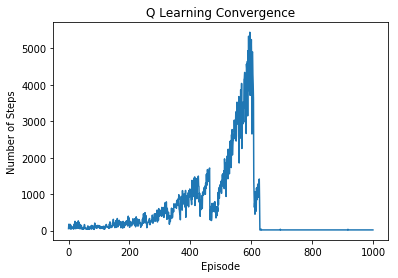

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
x = []
for i in range(1000):
    x.append(i)
y = agent.steps
plt.plot(x,y)
plt.ylabel('Number of Steps')
plt.xlabel('Episode')
plt.title('Q Learning Convergence')
plt.show()

In [8]:
min(agent.steps)

20

#### Optimal Policy

In [9]:
for i in range(BOARD_ROWS):
    print('---------------------------------------')
    row_string = "| "
    for j in range(BOARD_COLS):
        best_val = -1000
        for a in agent.Q_values[(i,j)]:
            if agent.Q_values[(i,j)][a] > best_val:
                best_val = agent.Q_values[(i,j)][a]
                best_move = a            
        row_string = row_string + " " + best_move + " |"
    print(row_string)
print('---------------------------------------')

---------------------------------------
|  down | left | left | down | left |
---------------------------------------
|  right | down | up | down | up |
---------------------------------------
|  down | left | up | left | up |
---------------------------------------
|  right | right | right | right | up |
---------------------------------------


### 2. If the connected graph does not have a Euler's Path

Training...
Training finished!


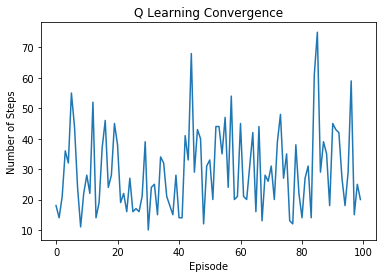

In [10]:
BOARD_ROWS = 3
BOARD_COLS = 3
START = (0, 0)
END = (0, 0)
agent = Agent()
agent.train(rounds=100)
x = []
for i in range(100):
    x.append(i)
y = agent.steps
plt.plot(x,y)
plt.ylabel('Number of Steps')
plt.xlabel('Episode')
plt.title('Q Learning Convergence')
plt.show()

#### If I set up the restriction that the agent should come back once covered all grids, not surprisingly, values in Q tables are very closed. 

In [11]:
agent.Q_values

{(0, 0): {'down': 3.2447, 'left': 3.0911, 'right': 3.0166, 'up': 3.1707},
 (0, 1): {'down': 2.9295, 'left': 3.4166, 'right': 2.8918, 'up': 2.762},
 (0, 2): {'down': 2.8401, 'left': 3.4984, 'right': 2.8021, 'up': 2.7602},
 (1, 0): {'down': 3.404, 'left': 3.2616, 'right': 3.4712, 'up': 3.2663},
 (1, 1): {'down': 3.1704, 'left': 3.1376, 'right': 2.8649, 'up': 2.9078},
 (1, 2): {'down': 2.6294, 'left': 2.9895, 'right': 2.7844, 'up': 3.4796},
 (2, 0): {'down': 2.8378, 'left': 2.8, 'right': 2.892, 'up': 3.0155},
 (2, 1): {'down': 2.7655, 'left': 2.9407, 'right': 3.1993, 'up': 2.9256},
 (2, 2): {'down': 2.6275, 'left': 2.7615, 'right': 2.6621, 'up': 3.2531}}

In [12]:
min(agent.steps)

10

### 3. Task for only coverage not getting back

In [13]:
BOARD_ROWS = 3
BOARD_COLS = 3
START = (0, 0)
# END = (0, 0)

class Agent:
    """
    Only coverage not get back 
    Same code except for cheking end
    """

    def __init__(self):
        self.actions = ["up", "down", "left", "right"]      # space
        self.State = State()
        self.is_end = self.State.is_end
        self.alpha = 0.3
        self.exp_rate = 1
        self.decay_gamma = 0.9
        self.Q_values = {}             # init Q values (dict)
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.Q_values[(i, j)] = {}
                for a in self.actions:
                    self.Q_values[(i, j)][a] = 0
        self.past_all = []
        for i in range(BOARD_ROWS):
            t = []
            for j in range(BOARD_COLS): 
                t.append(False)
            self.past_all.append(t)
        self.steps = []
    
    def optimal_action(self):
        max_value = -100
        action = ""
        for a in self.actions:
            next_value = self.Q_values[self.State.state][a]
            if next_value >= max_value:
                action = a
                max_value = next_value
        return action
    
    def get_action(self):
        if np.random.uniform(0, 1) <= self.exp_rate:
            up = self.State.next_position("up")
            down = self.State.next_position("down")
            left = self.State.next_position("left")
            right = self.State.next_position("right")
            rule = [self.past_all[up[0]][up[1]] is True,
                    self.past_all[down[0]][down[1]] is True,
                    self.past_all[left[0]][left[1]] is True,
                    self.past_all[right[0]][right[1]] is True ]
            if all(rule):
                action = np.random.choice(self.actions)
                return action
            else:
                while True:
                    action = np.random.choice(self.actions)
                    next_state = self.State.next_position(action)
                    if self.past_all[next_state[0]][next_state[1]] == False:
                        return action
                    else:
                        continue
        else:
            return self.optimal_action()
    
    def give_reward(self):
        reward = 0
        if self.past_all[self.State.state[0]][self.State.state[1]] is False:
            reward += 1
        else:
            reward -= .1
        return reward
    
    def set_action(self, action):
        curr_state = self.State.state
        self.past_all[curr_state[0]][curr_state[1]] = True
        next_state = self.State.next_position(action)  
        self.State = State(state=next_state)
        reward = self.give_reward()
        if self.past_all[next_state[0]][next_state[1]] is False:
            self.past_all[next_state[0]][next_state[1]] = True
#         if self.State.state==START and self.check_all_past():
#             reward += 1
        qs_of_next_state = []
        for q_value in self.Q_values[next_state]:  
            qs_of_next_state.append(self.Q_values[next_state][q_value])
        delta = self.alpha*(reward + self.decay_gamma*(max(qs_of_next_state)) -
                            self.Q_values[curr_state][action])
        self.Q_values[curr_state][action] = round(self.Q_values[curr_state][action]+delta, 4)
        

    def reset(self):
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.past_all[i][j] = False
        self.State = State()
        self.is_end = self.State.is_end
    
    def check_all_past(self):
        for i in self.past_all:
            for j in i:
                if j is False:
                    return False
        return True

    def train(self, rounds=100):
        print("Training...")
        for r in range(rounds): 
            self.reset()
            self.exp_rate *= 0.9
            step = 0
            while True:
                action = self.get_action()
                self.set_action(action)
                self.State.check_end()
                self.is_end = self.State.is_end
                step += 1
                #if (self.is_end == True) and (self.check_all_past() == True):
                if self.check_all_past() == True:
                    break
            self.steps.append(step)
        print("Training finished!")

Training...
Training finished!


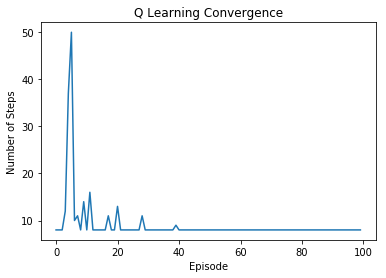

In [14]:
agent = Agent()
agent.train()
x = []
for i in range(100):
    x.append(i)
y = agent.steps
plt.plot(x,y)
plt.ylabel('Number of Steps')
plt.xlabel('Episode')
plt.title('Q Learning Convergence')
plt.show()

In [15]:
agent.Q_values

{(0, 0): {'down': 7.2934, 'left': 0.4081, 'right': 1.5354, 'up': 0.5001},
 (0, 1): {'down': 4.3425, 'left': 0.7249, 'right': 0.4561, 'up': 0.3272},
 (0, 2): {'down': 0.5331, 'left': 4.9081, 'right': 0.2365, 'up': 0.2793},
 (1, 0): {'down': 6.9928, 'left': 0.2797, 'right': 2.1414, 'up': 0.5395},
 (1, 1): {'down': 1.2388, 'left': 3.714, 'right': 1.0676, 'up': 0.9094},
 (1, 2): {'down': 0.5108, 'left': 1.3225, 'right': 0, 'up': 5.4172},
 (2, 0): {'down': 0, 'left': 0, 'right': 6.6588, 'up': 0},
 (2, 1): {'down': 0, 'left': 0.5358, 'right': 6.2877, 'up': 2.0883},
 (2, 2): {'down': 0, 'left': 0.5358, 'right': 0, 'up': 5.8754}}

In [16]:
min(agent.steps)

8

#### Optimal  Policy

In [17]:
for i in range(BOARD_ROWS):
    print('-----------------------')
    row_string = "| "
    for j in range(BOARD_COLS):
        best_val = -1000
        for a in agent.Q_values[(i,j)]:
            if agent.Q_values[(i,j)][a] > best_val:
                best_val = agent.Q_values[(i,j)][a]
                best_move = a            
        row_string = row_string + " " + best_move + " |"
    print(row_string)
print('-----------------------')

-----------------------
|  down | down | left |
-----------------------
|  down | left | up |
-----------------------
|  right | right | up |
-----------------------
